In [1]:
import matplotlib.pyplot as plt
import cv2 as cv
from cachetools import cached
import numpy as np
import random
from tqdm import tqdm

(1000, 1000, 3)


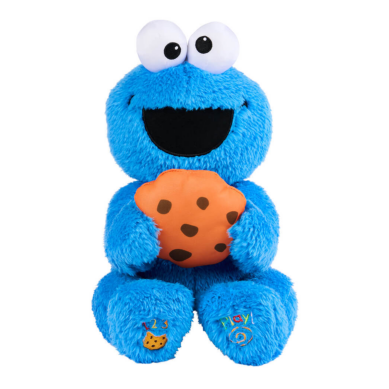

In [2]:
img = cv.imread("cookie-monster.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(img)
print(img.shape)
width, height, _ = img.shape

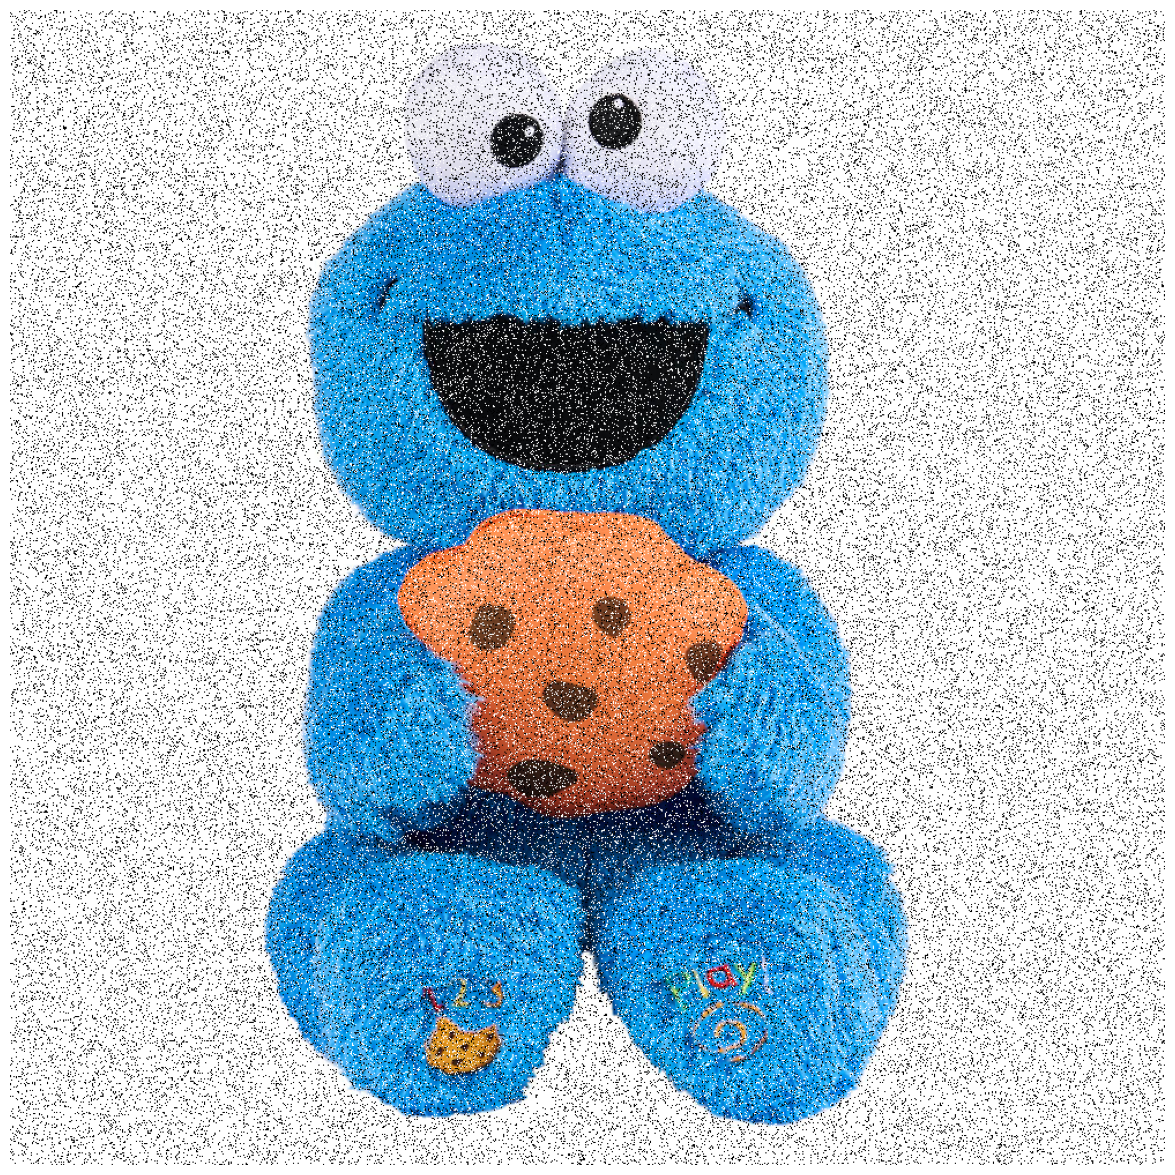

In [3]:
def apply_uniform_noise(noise_percent):
    points = np.random.uniform(0, 1, (width, height))

    noise_mask = points <= noise_percent
    salt_mask = np.random.rand(width, height) > 0.5

    noisy_img = img.copy()
    noisy_img[noise_mask & salt_mask] = (255, 255, 255)
    noisy_img[noise_mask & ~salt_mask] = (0, 0, 0)

    return noisy_img


plt.figure(figsize=(15, 15))
plt.axis("off")
plt.imshow(apply_uniform_noise(0.2))

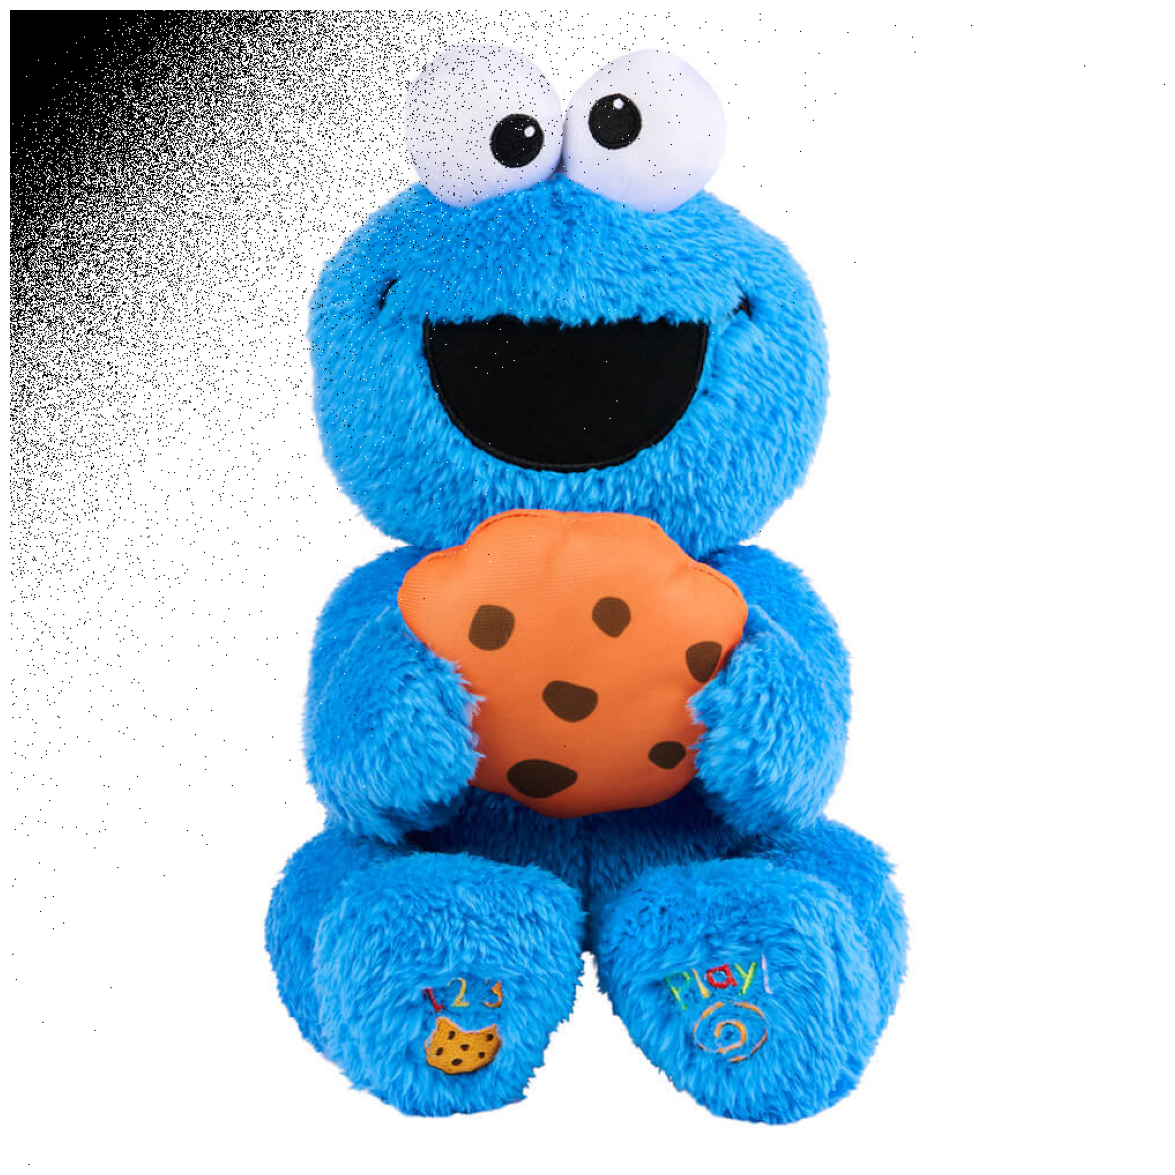

In [4]:
def apply_exponential_noise(noise_percent):
    noise_pixel_count = int(noise_percent * width * height)

    x = np.random.exponential(scale=1.0, size=noise_pixel_count)
    y = np.random.exponential(scale=1.0, size=noise_pixel_count)

    x = ((x - x.min()) / (x.max() - x.min()) * (width - 1)).astype(np.int32)
    y = ((y - y.min()) / (y.max() - y.min()) * (height - 1)).astype(np.int32)

    noisy_img = img.copy()

    salt_mask = np.random.rand(noise_pixel_count) > 0.5

    noisy_img[y[salt_mask], x[salt_mask]] = (255, 255, 255)
    noisy_img[y[~salt_mask], x[~salt_mask]] = (0, 0, 0)

    return noisy_img


plt.figure(figsize=(15, 15))
plt.axis("off")
plt.imshow(apply_exponential_noise(0.2))

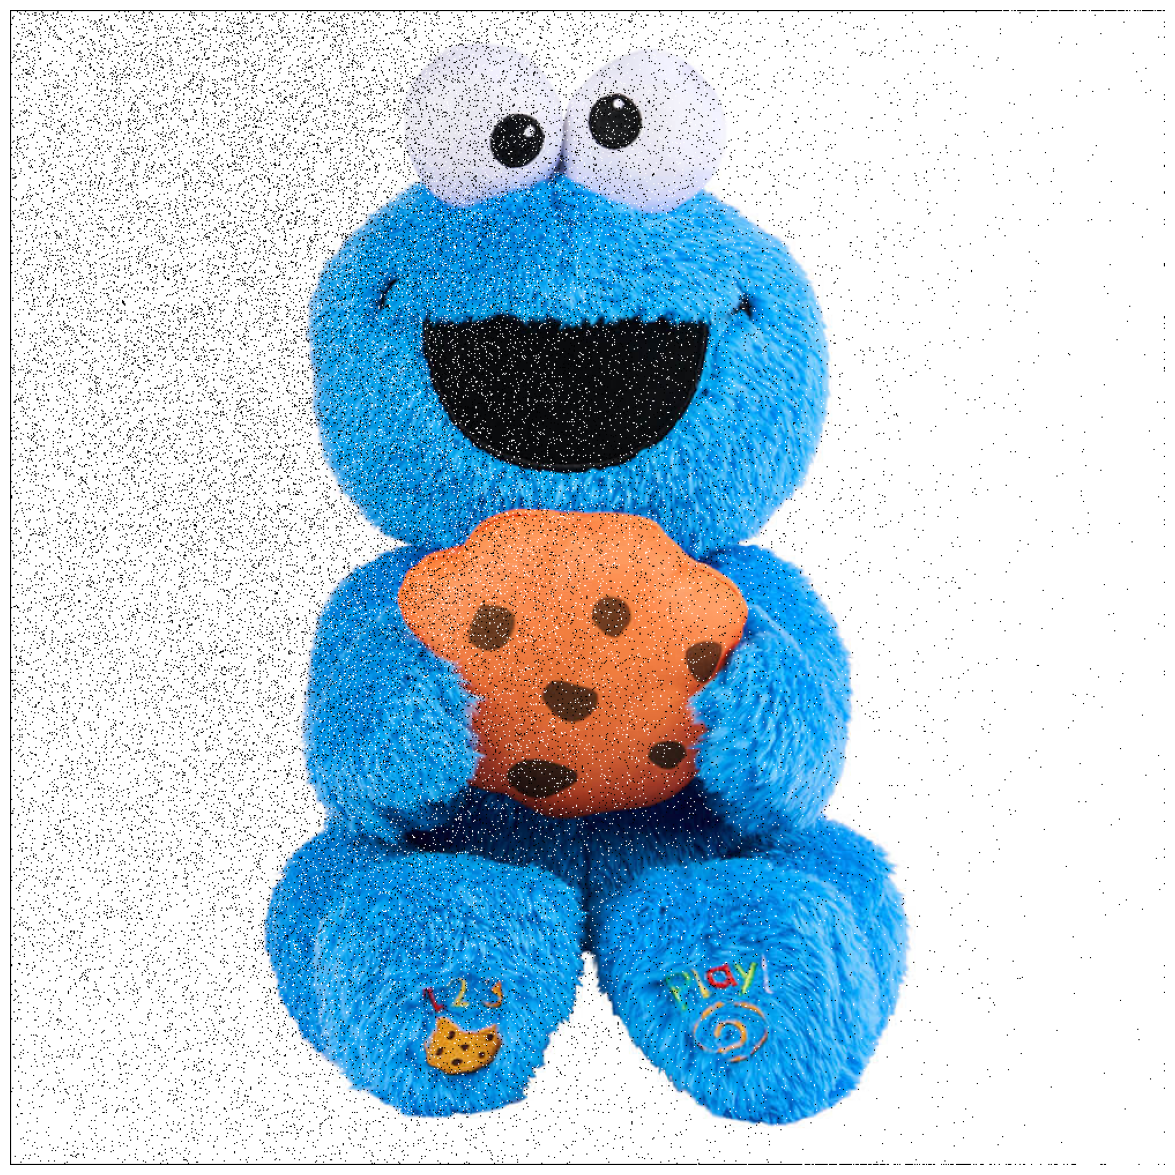

In [5]:
def apply_normal_noise(noise_percent):
    noise_pixel_count = int(noise_percent * width * height)

    locx = np.random.uniform(0, width)
    locy = np.random.uniform(0, height)
    scalex = np.random.uniform(0, width)
    scaley = np.random.uniform(0, height)
    x = np.random.normal(loc=locx, scale=scalex, size=noise_pixel_count)
    y = np.random.normal(loc=locy, scale=scaley, size=noise_pixel_count)

    x = np.clip(x, 0, width - 1).astype(np.int32)
    y = np.clip(y, 0, height - 1).astype(np.int32)

    noisy_img = img.copy()

    salt_mask = np.random.rand(noise_pixel_count) > 0.5

    noisy_img[y[salt_mask], x[salt_mask]] = (255, 255, 255)
    noisy_img[y[~salt_mask], x[~salt_mask]] = (0, 0, 0)

    return noisy_img


plt.figure(figsize=(15, 15))
plt.axis("off")
plt.imshow(apply_normal_noise(0.2))

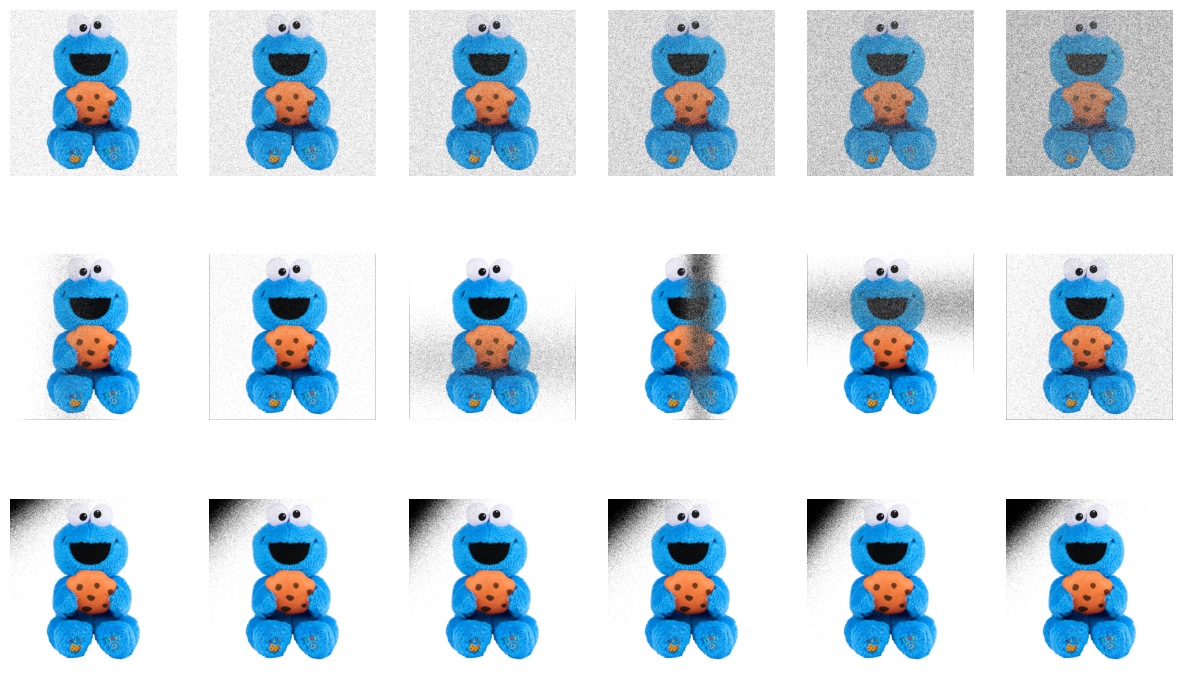

In [6]:
plt.figure(figsize=(15, 9))
noise_ratios = (0.1, 0.15, 0.2, 0.3, 0.4, 0.5)
for i in range(len(noise_ratios)):
    plt.subplot(3, len(noise_ratios), i + 1)
    plt.axis("off")
    plt.imshow(apply_uniform_noise(noise_ratios[i]))

    plt.subplot(3, len(noise_ratios), i + 1 + len(noise_ratios))
    plt.axis("off")
    plt.imshow(apply_normal_noise(noise_ratios[i]))

    plt.subplot(3, len(noise_ratios), i + 1 + 2 * len(noise_ratios))
    plt.axis("off")
    plt.imshow(apply_exponential_noise(noise_ratios[i]))

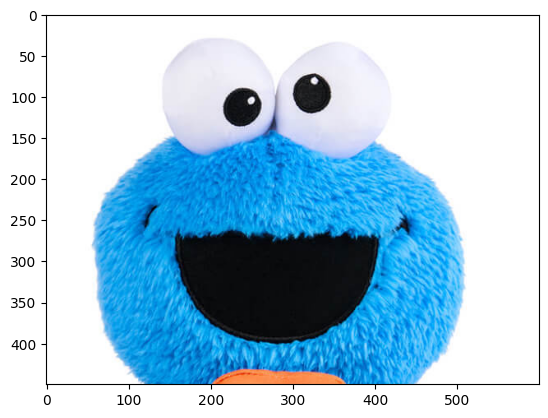

In [7]:
def get_face(img):
    return img[0:450, 200:800]


# plt.axis('off')
plt.imshow(get_face(img))

In [8]:
def is_corrupted(noisy_img):
    face = get_face(img)
    noisy_face = get_face(noisy_img)

    total = 0
    ruined = 0

    mask = face == (255, 255, 255)
    mask = np.all(mask, axis=2)
    ruined -= mask.sum()
    mask = ~mask
    total = mask.sum()

    corrupt_mask = np.all(noisy_face == (255, 255, 255), axis=2) | np.all(
        noisy_face == (0, 0, 0), axis=2
    )
    ruined += corrupt_mask.sum()

    return ruined / total > 0.2


is_corrupted(apply_normal_noise(0.2))

np.False_

In [9]:
@cached({})
def calculate_corruption(func, noise_ratio: float, count: int = 100):
    ans = 0
    for _ in tqdm(range(count)):
        noisy_img = func(noise_ratio)
        if is_corrupted(noisy_img):
            ans += 1
    return ans

In [10]:
for func in (apply_normal_noise, apply_uniform_noise, apply_exponential_noise):
    for noise_ratio in (0.2, 0.3, 0.4, 0.5):
        rate = calculate_corruption(func, noise_ratio)
        print(func.__name__, noise_ratio, rate)

100%|██████████| 100/100 [00:01<00:00, 57.93it/s]


apply_normal_noise 0.2 6


100%|██████████| 100/100 [00:02<00:00, 45.70it/s]


apply_normal_noise 0.3 14


100%|██████████| 100/100 [00:02<00:00, 37.28it/s]


apply_normal_noise 0.4 19


100%|██████████| 100/100 [00:03<00:00, 31.40it/s]


apply_normal_noise 0.5 32


100%|██████████| 100/100 [00:01<00:00, 55.53it/s]


apply_uniform_noise 0.2 41


100%|██████████| 100/100 [00:01<00:00, 51.79it/s]


apply_uniform_noise 0.3 100


100%|██████████| 100/100 [00:02<00:00, 48.27it/s]


apply_uniform_noise 0.4 100


100%|██████████| 100/100 [00:02<00:00, 45.03it/s]


apply_uniform_noise 0.5 100


100%|██████████| 100/100 [00:01<00:00, 59.75it/s]


apply_exponential_noise 0.2 0


100%|██████████| 100/100 [00:02<00:00, 46.64it/s]


apply_exponential_noise 0.3 0


100%|██████████| 100/100 [00:02<00:00, 38.30it/s]


apply_exponential_noise 0.4 0


100%|██████████| 100/100 [00:03<00:00, 32.71it/s]

apply_exponential_noise 0.5 0


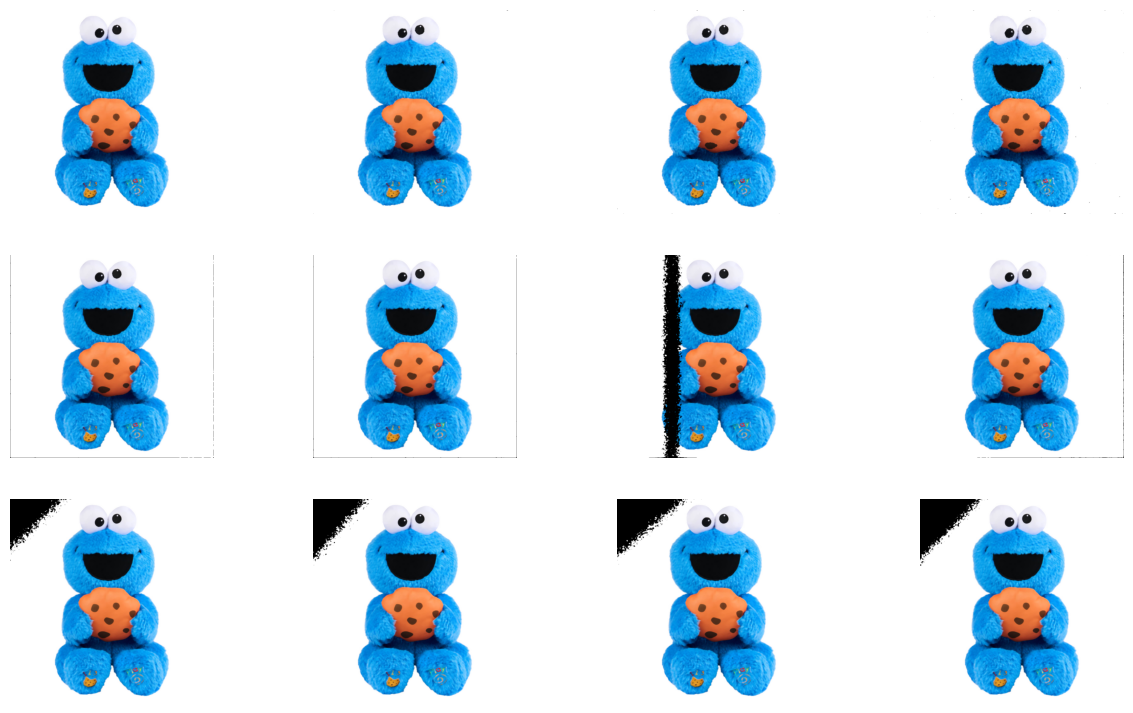

In [11]:
plt.figure(figsize=(15, 9))
random.seed(42)
noise_ratios = (0.2, 0.3, 0.4, 0.5)
ksize = 7
for i in range(len(noise_ratios)):
    plt.subplot(3, len(noise_ratios), i + 1)
    plt.axis("off")
    plt.imshow(cv.medianBlur(apply_uniform_noise(noise_ratios[i]), ksize))

    plt.subplot(3, len(noise_ratios), i + 1 + len(noise_ratios))
    plt.axis("off")
    plt.imshow(cv.medianBlur(apply_normal_noise(noise_ratios[i]), ksize))

    plt.subplot(3, len(noise_ratios), i + 1 + 2 * len(noise_ratios))
    plt.axis("off")
    plt.imshow(cv.medianBlur(apply_exponential_noise(noise_ratios[i]), ksize))

In [12]:
calculate_corruption(apply_uniform_noise, 0.2, 1000)

100%|██████████| 1000/1000 [00:18<00:00, 55.35it/s]


483